# Analysis of WineEnthusiast.com reviews

Stemming of corpus, TF-IDF, LSA, dendrograms, plots, and word clouds.


In [1]:
import numpy as np
import pandas as pd
import datetime

import re
import os
import codecs
import dill

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import MDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer


from scipy.cluster.hierarchy import ward, dendrogram


from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score 
from sklearn.metrics import adjusted_rand_score, silhouette_score


from gensim import corpora, models, similarities 

from scipy.cluster.hierarchy import ward, dendrogram, linkage

import multiprocess as multiprocessing

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import mpld3

sns.set_context('poster')
sns.set_palette('dark')
sns.set_style('white')

In [2]:
data = pd.read_pickle('../priv/pkl/07_wine_enthusiast_data_small_cleaned.pkl')

In [3]:
data.shape

(29674, 16)

In [4]:
data.head(2)

,alcohol,appellation,bottle_size,category,date_published,designation,importer,list_url_no,price,rating,review,title,url,variety,winery,year
137978,NaN,"Willamette Valley, Willamette Valley, Oregon, US",750.0,Red,2008-04-01,Athena,NaN,4611,34.0,88.0,"Aromatic and floral, this lovely bottle has a ...",Boedecker Cellars 2005 Athena Pinot Noir (Will...,http://www.winemag.com/buying-guide/boedecker-...,Pinot Noir,Boedecker Cellars,2005
114522,15.0,"Anderson Valley, Mendocino/Lake Counties, Cali...",750.0,Red,2009-12-31,Ferrington Vineyard,NaN,3828,60.0,94.0,MacPhail continues its string of super 2007 vi...,MacPhail 2007 Ferrington Vineyard Pinot Noir (...,http://www.winemag.com/buying-guide/macphail-2...,Pinot Noir,MacPhail,2007


## Stemming and tokenizing

In [11]:
def tokenize_with_lemmatizing(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(['s',"'s", "n't", 'cab', 'cabernet', 'year', 'alcohol','price','wine','winery','drink','flavor'])
    
    varieties = np.array(['Chardonnay', 'Pinot', 'Nebbiolo', 'Zinfandel', 'Riesling',
           'Syrah', 'Tempranillo', 'Cabernet', 'Sauvignon', 'Franc',
           'Gruner','Veltliner', 'Chenin', 'Merlot', 'Viognier', 'Malbec',
           'Rose', 'Sauvignon', 'Blanc', 'Grenache', 'Syrah', 'Sirah', 'Shiraz','Albarino',
           'Pinot', 'Barbera', 'Gewurztraminer', 'Sangiovese',
           'Grigio', 'Gamay', 'Nero', 'Avola', 'Carmenere','Corvina','Noir','White','Red'])
      
    stopwords.extend([x.lower() for x in varieties])

    #text = text.lower()
    text = (text
            .replace('acidity', 'acid')
            .replace('balanced', 'balance')
            .replace('complexity', 'complex')
            .replace('minerality', 'mineral')
            .replace('mouthfeel', 'mouth')
            .replace('peppery', 'pepper')
            .replace('richness','rich')
            .replace('earthy', 'earth')
            .replace('fruity', 'fruit')
            .replace('structured', 'structure')
            .replace('toasty','toast')
            .replace('smoky', 'smoke')
            .replace('spicy','spice')
            .replace('tannin', 'tannic')
            .replace('aging', 'age')
            .replace('oaky','oak')
            .replace('aroma', 'aromatic')
            .replace('concentration', 'concentrated')
            .replace('tannic', 'tannin')
            .replace('aromatictic', 'aromatics')
            .replace('flower', 'floral')
            .replace('fresh', 'freshness')
            .replace('intensity','intense')
            .replace('freshnessness', 'freshness')
            .replace('refreshnessing', 'refreshing')
            .replace('herbal', 'herb')
            .replace('sweetness', 'sweet'))
    
    # Tokenize sentences and words
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    # Remove non-alphanumeric terms, convert to lower case
    tokens = [word for word in tokens if re.search('[a-zA-Z]', word)]
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords]
    
    # Lemmatize the words
    tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

def tokenize_with_stemming(text):
    stemmer = SnowballStemmer('english')
    
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(['s',"'s", "n't", 'cab', 'cabernet', 'year', 'alcohol','price','wine','winery','drink','flavor'])
    
    varieties = np.array(['Chardonnay', 'Pinot', 'Nebbiolo', 'Zinfandel', 'Riesling',
           'Syrah', 'Tempranillo', 'Cabernet', 'Sauvignon', 'Franc',
           'Gruner','Veltliner', 'Chenin', 'Merlot', 'Viognier', 'Malbec',
           'Rose', 'Sauvignon', 'Blanc', 'Grenache', 'Syrah', 'Sirah', 'Shiraz','Albarino',
           'Pinot', 'Barbera', 'Gewurztraminer', 'Sangiovese',
           'Grigio', 'Gamay', 'Nero', 'Avola', 'Carmenere','Corvina','Noir','White','Red'])
      
    stopwords.extend([x.lower() for x in varieties])
    
    #text = text.lower()
    text = (text
            .replace('acidity', 'acid')
            .replace('balanced', 'balance')
            .replace('complexity', 'complex')
            .replace('minerality', 'mineral')
            .replace('mouthfeel', 'mouth')
            .replace('peppery', 'pepper')
            .replace('richness','rich')
            .replace('earthy', 'earth')
            .replace('fruity', 'fruit')
            .replace('structured', 'structure')
            .replace('toasty','toast')
            .replace('smoky', 'smoke')
            .replace('spicy','spice')
            .replace('tannin', 'tannic')
            .replace('aging', 'age')
            .replace('oaky', 'oak')
            .replace('aroma', 'aromatic')
            .replace('concentration', 'concentrated')
            .replace('tannic', 'tannin')
            .replace('aromatictic', 'aromatics')
            .replace('flower', 'floral')
            .replace('fresh','freshness')
            .replace('intensity','intense')
            .replace('freshnessness', 'freshness')
            .replace('refreshnessing', 'refreshing')
            .replace('herbal', 'herb')
            .replace('sweetness', 'sweet'))
    
    # Tokenize sentences and words
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    # Remove non-alphanumeric terms, convert to lower case
    tokens = [word for word in tokens if re.search('[a-zA-Z]', word)]
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords]
    
    # Stem the words
    tokens = [stemmer.stem(word) for word in tokens]
    
    return tokens
    
def tokenize(text):
    
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(['s',"'s", "n't", 'cab', 'cabernet', 'year', 'alcohol','price','wine','winery','drink','flavor'])
    
    varieties = np.array(['Chardonnay', 'Pinot', 'Nebbiolo', 'Zinfandel', 'Riesling',
           'Syrah', 'Tempranillo', 'Cabernet', 'Sauvignon', 'Franc',
           'Gruner','Veltliner', 'Chenin', 'Merlot', 'Viognier', 'Malbec',
           'Rose', 'Sauvignon', 'Blanc', 'Grenache', 'Syrah', 'Sirah', 'Shiraz','Albarino',
           'Pinot', 'Barbera', 'Gewurztraminer', 'Sangiovese',
           'Grigio', 'Gamay', 'Nero', 'Avola', 'Carmenere','Corvina','Noir','White','Red'])
      
    stopwords.extend([x.lower() for x in varieties])
    
    #text = text.lower()
    text = (text
            .replace('acidity', 'acid')
            .replace('balanced', 'balance')
            .replace('complexity', 'complex')
            .replace('minerality', 'mineral')
            .replace('mouthfeel', 'mouth')
            .replace('peppery', 'pepper')
            .replace('richness','rich')
            .replace('earthy', 'earth')
            .replace('fruity', 'fruit')
            .replace('structured', 'structure')
            .replace('toasty','toast')
            .replace('smoky', 'smoke')
            .replace('spicy','spice')
            .replace('tannin', 'tannic')
            .replace('aging', 'age')
            .replace('oaky', 'oak')
            .replace('aroma', 'aromatic')
            .replace('concentration', 'concentrated')
            .replace('tannic', 'tannin')
            .replace('aromatictic', 'aromatics')
            .replace('flower', 'floral')
            .replace('fresh','freshness')
            .replace('intensity','intense')
            .replace('freshnessness', 'freshness')
            .replace('refreshnessing', 'refreshing')
            .replace('herbal', 'herb')
            .replace('sweetness', 'sweet'))
    
    # Tokenize sentences and words
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    # Remove non-alphanumeric terms, convert to lower case
    tokens = [word for word in tokens if re.search('[a-zA-Z]', word)]
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords]
    
    return tokens

In [10]:
data['review'] = data.review.str.lower()

#data['word_token'] = data.review.apply(tokenize)
#data['word_stem'] = data.review.apply(tokenize_with_stemming)
data['word_lemm'] = data.review.apply(tokenize_with_lemmatizing)
print('done')

done


In [11]:
data['word_lemm'].head(5)

137978    [aromatics, floral, lovely, bottle, tangy, nic...
114522    [macphail, continues, string, super, vineyard-...
85977     [fine, get, pay, dry, silky, crisp, acid, yet,...
8586      [tannin, earth, defined, principally, flavor, ...
12846     [big, bold, dark, chewy, build, upon, substant...
Name: word_lemm, dtype: object

In [12]:
corpus = data.review.tolist()
print('done')

done


In [ ]:
tp = tokenize_with_lemmatizing(corpus)

## TF-IDF

In [15]:
tfidf = TfidfVectorizer(max_df = 0.98, max_features=10000,
                       min_df=0.02, stop_words='english', use_idf=True,
                       tokenizer=tokenize_with_lemmatizing)

tfidf_matrix = tfidf.fit_transform(corpus)
tfidf_feat_names = np.array(tfidf.get_feature_names())

with open('../pkl/09_wine_ethusiast_analysis_tfidf_matrix.pkl', 'wb') as fh:
    dill.dump(tfidf_matrix, fh)

print(tfidf_matrix.shape)
print(len(tfidf_feat_names))
print(tfidf_feat_names)

! echo "pushover 'tfidf finished'" | /bin/zsh

(29674, 172)
172
['acid' 'add' 'age' 'alongside' 'apple' 'apricot' 'aromatics' 'attractive'
 'balance' 'berry' 'best' 'big' 'bit' 'bitter' 'black' 'blackberry' 'blend'
 'blueberry' 'body' 'bouquet' 'bright' 'cassis' 'cedar' 'character'
 'cherry' 'chocolate' 'cinnamon' 'citrus' 'clean' 'close' 'clove' 'coffee'
 'cola' 'color' 'come' 'complex' 'concentrated' 'core' 'creamy' 'crisp'
 'currant' 'dark' 'deep' 'delicate' 'delicious' 'delivers' 'dense' 'dried'
 'dry' 'dusty' 'earth' 'easy' 'edge' 'elegant' 'end' 'exotic' 'feel' 'fine'
 'finish' 'firm' 'flavor' 'floral' 'followed' 'food' 'freshness' 'fruit'
 'full-bodied' 'good' 'grape' 'grapefruit' 'great' 'green' 'hard' 'heavy'
 'herb' 'high' 'hint' 'honey' 'imported' 'intense' 'jammy' 'juicy' 'layer'
 'lead' 'lean' 'leather' 'lemon' 'licorice' 'light' 'like' 'lime' 'little'
 'lively' 'long' 'lot' 'lush' 'make' 'meat' 'melon' 'mineral' 'mix' 'mouth'
 'need' 'new' 'nice' 'nose' 'note' 'oak' 'offer' 'open' 'orange' 'pair'
 'palate' 'peach' 'pe

In [16]:
tfidf_matrix.shape

(29674, 172)

In [17]:
tfidf_cs = 1 - pairwise_distances(tfidf_matrix, metric='cosine', n_jobs=-1)
tfidf_ec = pairwise_distances(tfidf_matrix, metric='euclidean', n_jobs=-1)

# with open('../priv/pkl/09_wine_ethusiast_analysis_tfidf_ec.pkl', 'wb') as fh:
#     dill.dump(tfidf_ec, fh)
    
# with open('../priv/pkl/09_wine_ethusiast_analysis_tfidf_cs.pkl', 'wb') as fh:
#     dill.dump(tfidf_cs, fh)

In [18]:
tfidf_cs.shape, tfidf_ec.shape

((29674, 29674), (29674, 29674))

In [19]:
tfidf_small = TfidfVectorizer(max_df = 0.9, max_features=10000,
                       min_df=0.1, stop_words='english', use_idf=True,
                       tokenizer=tokenize_with_lemmatizing)

tfidf_small_matrix = tfidf_small.fit_transform(corpus)
tfidf_small_feat_names = np.array(tfidf_small.get_feature_names())

with open('../priv/pkl/09_wine_ethusiast_analysis_tfidf_small_matrix.pkl', 'wb') as fh:
    dill.dump(tfidf_small_matrix, fh)

print(tfidf_small_matrix.shape)
print(len(tfidf_small_feat_names))
print(tfidf_small_feat_names)
! echo "pushover 'tfidf small finished'" | /bin/zsh

(29674, 26)
26
['acid' 'aromatics' 'balance' 'berry' 'black' 'blackberry' 'cherry' 'dry'
 'finish' 'flavor' 'freshness' 'fruit' 'herb' 'mouth' 'nose' 'note' 'oak'
 'palate' 'pepper' 'plum' 'rich' 'ripe' 'soft' 'spice' 'sweet' 'tannin']


In [20]:
tfidf_small_ec = pairwise_distances(tfidf_small_matrix, metric='euclidean', n_jobs=-1)
tfidf_small_cs = 1 - pairwise_distances(tfidf_small_matrix, metric='cosine', n_jobs=-1)

with open('../priv/pkl/09_wine_ethusiast_analysis_tfidf_small_ec.pkl', 'wb') as fh:
    dill.dump(tfidf_small_ec, fh)
    
with open('../priv/pkl/09_wine_ethusiast_analysis_tfidf_small_cs.pkl', 'wb') as fh:
    dill.dump(tfidf_small_cs, fh)

## Dendrograms

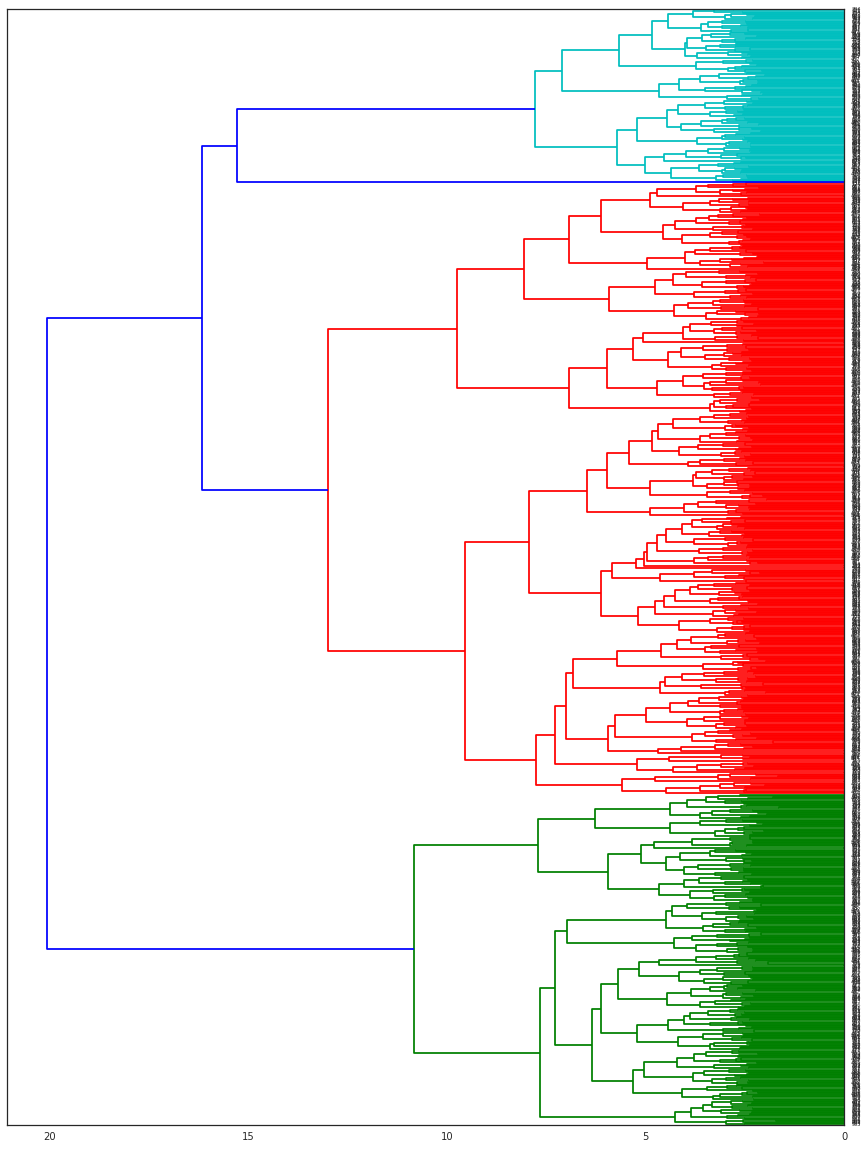

In [22]:
# Dendrogram for the large tfidf has ~ 4-7 clusters
for i in range(1):
    tfidf_linkage = tfidf.fit_transform(np.random.choice(corpus, 1000)) 

    tfidf_linkage_ec = pairwise_distances(tfidf_linkage, metric='euclidean', n_jobs=-1)
    tfidf_linkage_cs = 1. - pairwise_distances(tfidf_linkage, metric='cosine', n_jobs=-1)
    
    Z = linkage(tfidf_linkage_ec, method='ward')

    fig, ax = plt.subplots(figsize=(15, 20))
    ax = dendrogram(Z, orientation='left')
    plt.savefig('../figures/09_wine_ethusiast_analysis_dendrogram_large_{}.pdf'.format(i+1))
#     fig.close()

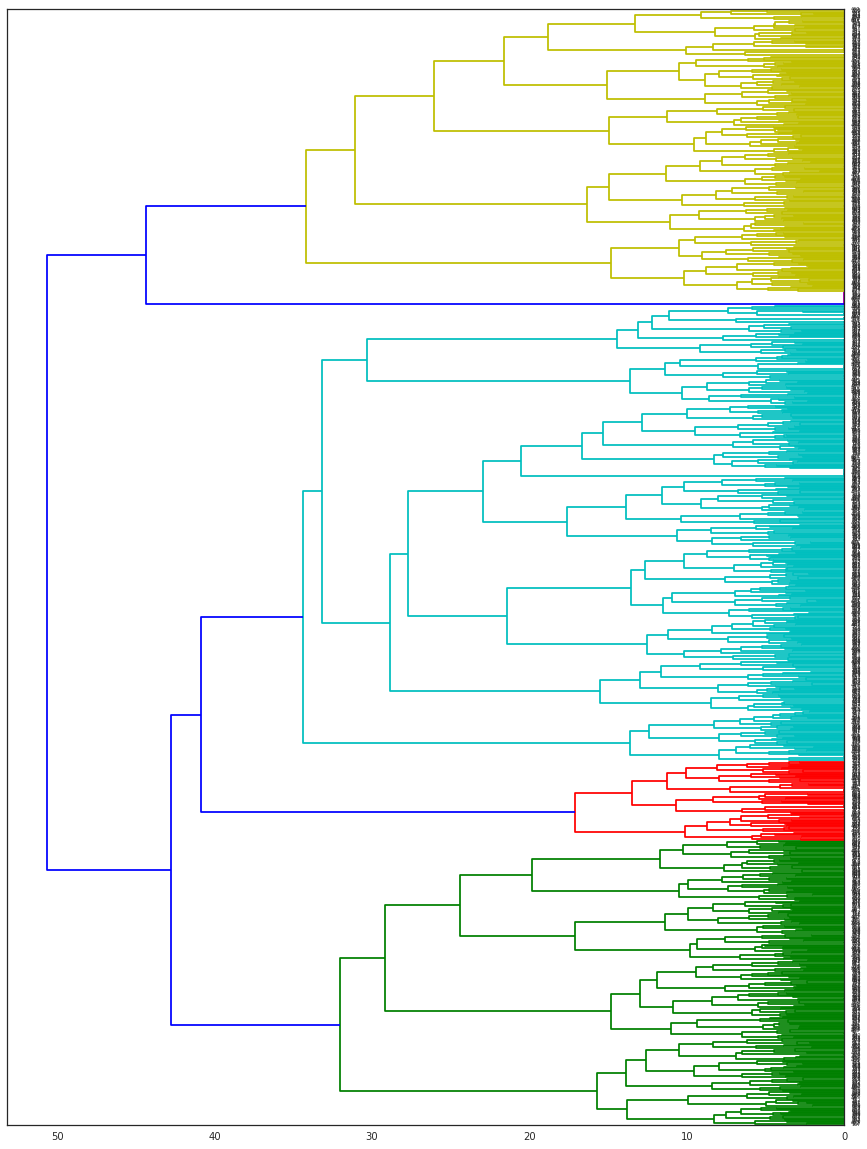

In [23]:
# Dendrogram for the small tfidf has ~ 4-7 clusters
for i in range(1):
    tfidf_linkage = tfidf_small.fit_transform(np.random.choice(corpus, 1000))

    tfidf_linkage_ec = pairwise_distances(tfidf_linkage, metric='euclidean', n_jobs=-1)
    tfidf_linkage_cs = 1. - pairwise_distances(tfidf_linkage, metric='cosine', n_jobs=-1)

    Z = linkage(tfidf_linkage_ec, method='ward')

    fig, ax = plt.subplots(figsize=(15, 20))
    ax = dendrogram(Z, orientation='left')
    plt.savefig('../figures/09_wine_ethusiast_analysis_dendrogram_small_{}.pdf'.format(i+1))
#     fig.close()

## LSA (Truncated SVD and K-means)

In [134]:
tfidf_matrix.shape, tfidf_small_matrix.shape

((29674, 172), (29674, 26))

In [33]:
svd_list = list()
for n_components in range(50,3,-1):
    svd = TruncatedSVD(n_components)
    
    tmp = svd.fit(tfidf_matrix)
    expl_var = svd.explained_variance_ratio_.sum()
    
    svd_list.append(pd.Series({'comp':n_components, 'expl_var':expl_var}))
    
svd_df = pd.concat(svd_list,axis=1).T

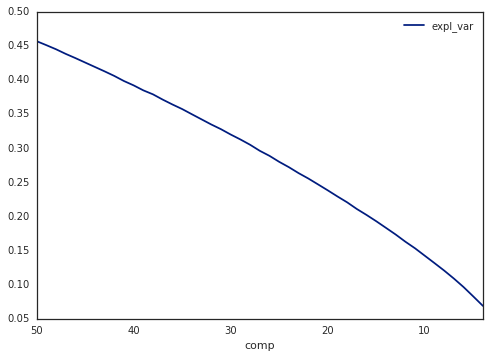

In [35]:
svd_df.plot('comp','expl_var')

In [36]:
#n_components = 7

svd = TruncatedSVD(30)
normalizer = Normalizer(copy=True)
lsa = make_pipeline(svd, normalizer)

# X_lsa = lsa.fit_transform(tfidf_small_matrix)
X_lsa = lsa.fit_transform(tfidf_matrix)

In [58]:
km_list = list()

km_data_list = list()
km_data_tmp = data[['category','variety']]
km_word_list = list()

for nclusters in range(3,8):
    
    km = KMeans(n_clusters=nclusters, init='k-means++', 
                max_iter=100, n_init=16, n_jobs=16)
    
    X_km = km.fit_predict(X_lsa)
    clusters = km.predict(X_lsa)

    #order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    original_space_centroids = svd.inverse_transform(km.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    
    km_word_list.append(tfidf_feat_names[order_centroids[:,:10]])
    
    km_list.append(pd.Series({'nclust':nclusters, 
                              'km':km, 
                              'predict': X_km,
                              'clusters': clusters,
                              'intertia':km.inertia_,
                              'centroids':order_centroids}).T)

    print(nclusters)
    
    km_data_tmp['cluster'] = clusters
    km_group_by = (km_data_tmp
                   .groupby(['cluster','category','variety'])
                   .size()
                   .reset_index(level=[1,2])
                   .rename(columns={0:'count'})
                   .assign(nclusters=nclusters))
    
    km_data_list.append(km_group_by)

    for row in range(order_centroids.shape[0]):
        print(tfidf_feat_names[order_centroids[row,:10]])
        print(km_group_by.loc[row])
        print('')
        
km_data_df = pd.concat(km_data_list, axis=0)
km_data_df = km_data_df.reset_index()

print(km_data_df[['cluster', 'intertia']])

km_data_df.plot('cluster','intertia')

3


/home/ubuntu/miniconda/envs/scienv3/lib/python3.5/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['fruit' 'tannin' 'rich' 'acid' 'ripe' 'age' 'structure' 'year' 'flavor'
 'spice']
        category             variety  count  nclusters
cluster                                               
0            Red      Cabernet Franc    419          3
0            Red  Cabernet Sauvignon    417          3
0            Red             Corvina    160          3
0            Red              Malbec    303          3
0            Red              Merlot    299          3
0            Red            Nebbiolo    178          3
0            Red          Pinot Noir    423          3
0            Red      Portuguese Red   1426          3
0            Red          Sangiovese    186          3
0            Red               Syrah    342          3
0            Red         Tempranillo     92          3
0            Red           Zinfandel    340          3
0           Rose                Rose    436          3
0          White          Chardonnay    266          3
0          White      Gewurztraminer 

KeyError: "['intertia'] not in index"

# LSA Cluster Plots

In [299]:
# Select the top N members of each plot

plot_num = 5
km_data_top = (km_data_df
                    .groupby(['nclusters','cluster'], group_keys=False)
                    .apply(lambda x: x.sort_values('count').iloc[-1*plot_num:].reset_index(drop=True) ))
km_data_top.index += 1

km_data_top.head(10)

,cluster,category,variety,count,nclusters
1,0,Red,Cabernet Franc,419,3
2,0,White,Gruner Veltliner,421,3
3,0,Red,Pinot Noir,423,3
4,0,Rose,Rose,436,3
5,0,Red,Portuguese Red,1426,3
1,1,Red,Merlot,1152,3
2,1,Red,Corvina,1177,3
3,1,Red,Sangiovese,1263,3
4,1,Red,Nebbiolo,1295,3
5,1,Red,Tempranillo,1335,3


In [300]:
# The count for the other members of each of the clusters

km_data_rest = ((km_data_df[['nclusters','cluster','count']]
                    .groupby(['nclusters','cluster'])
                    .apply(lambda x: x.sort_values('count').iloc[:-1*plot_num].sum() ))
                .drop(['nclusters','cluster'],axis=1)).reset_index()

km_data_rest.index = pd.Index([0]*km_data_rest.shape[0])

km_data_rest.head(10)

,nclusters,cluster,count
0,3,0,3550
0,3,1,7189
0,3,2,3225
0,4,0,2617
0,4,1,2573
0,4,2,2756
0,4,3,3738
0,5,0,1537
0,5,1,1691
0,5,2,3637


In [301]:
# Combine the two dataframes and sort values

km_data_bar = ((pd.concat([km_data_top, km_data_rest], axis=0)
 .groupby(['nclusters','cluster'])
 .apply(lambda x: x.sort_values('count',ascending=True)))
 .reset_index(level=[0,1],drop=True)
 .sort_index(ascending=False)
 .sort_values(['nclusters','cluster']))

km_data_bar.head()

,category,cluster,count,nclusters,variety
5,Red,0,1426,3,Portuguese Red
4,Rose,0,436,3,Rose
3,Red,0,423,3,Pinot Noir
2,White,0,421,3,Gruner Veltliner
1,Red,0,419,3,Cabernet Franc


In [ ]:
# Calculate cumulative sums for plotting the overlayed bars

km_data_cumsum = (((km_data_bar
.groupby(['nclusters','cluster'])
.apply(lambda x: x['count'].cumsum()))
 .stack()
 .reset_index()
 .rename(columns={'count':'index',0:'cumsum'})
 .set_index('index'))
.sort_index()
.sort_values(['nclusters','cluster'])).reset_index()

km_data_cumsum.query('nclusters==4')#.head()

In [303]:
# Merge the cumulative sums

km_data_bar = (pd.merge((pd.merge(km_data_bar.reset_index(), km_data_cumsum, 
                     on=['index','nclusters','cluster'])
            .sort_values('index')
            .sort_values(['nclusters','cluster'])).reset_index(drop=True),
           (km_data_df[['nclusters','cluster','count']]
            .groupby(['nclusters','cluster'])
            .sum()
            .reset_index()),
          how='left',
          on=['nclusters','cluster'],
          suffixes=('','_total')))

km_data_bar.head(10)

,index,category,cluster,count,nclusters,variety,cumsum,count_total
0,0,NaN,0,3550,3,NaN,6675,6675
1,1,Red,0,419,3,Cabernet Franc,3125,6675
2,2,White,0,421,3,Gruner Veltliner,2706,6675
3,3,Red,0,423,3,Pinot Noir,2285,6675
4,4,Rose,0,436,3,Rose,1862,6675
5,5,Red,0,1426,3,Portuguese Red,1426,6675
6,0,NaN,1,7189,3,NaN,13411,13411
7,1,Red,1,1152,3,Merlot,6222,13411
8,2,Red,1,1177,3,Corvina,5070,13411
9,3,Red,1,1263,3,Sangiovese,3893,13411


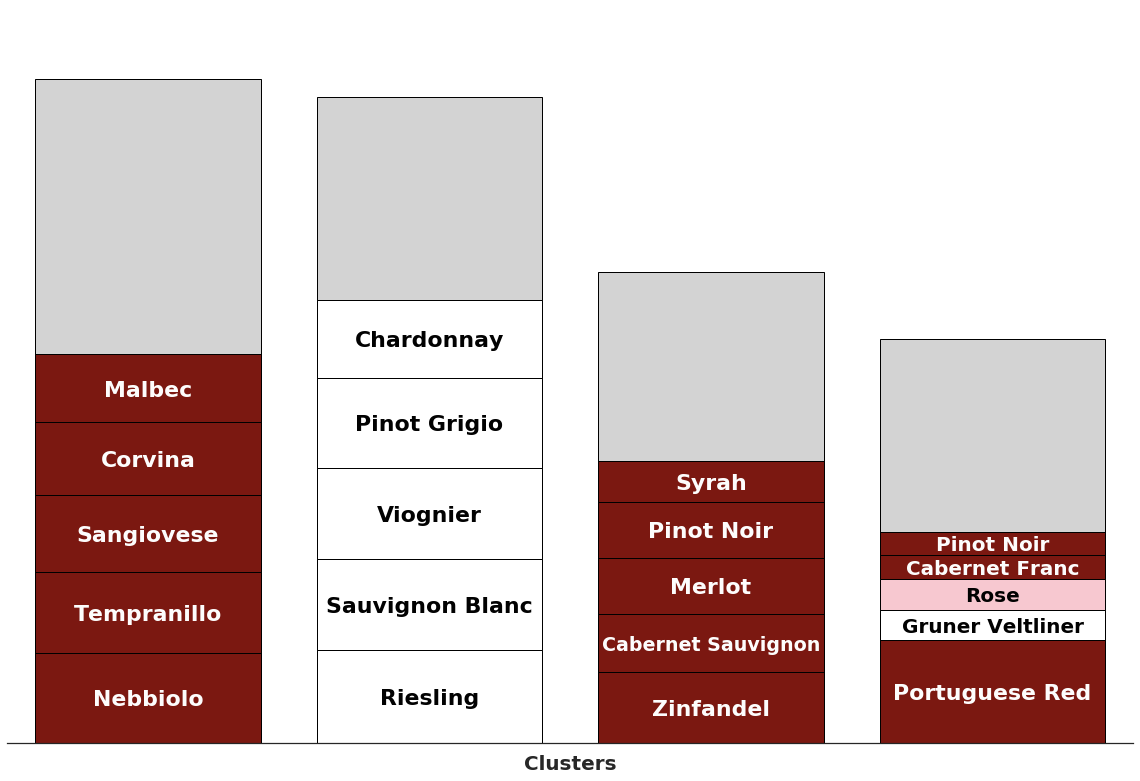

In [428]:
# The plot

sns.set_context('notebook')

fig, ax = plt.subplots(figsize=(16,11))

tmp = km_data_bar.loc[km_data_bar.nclusters==4]

color_list = {'Red':sns.color_palette()[2], 'Rose':'pink', 'White':'white'}

dat = tmp.loc[tmp['index']==0]
sns.barplot(x='cluster', y='cumsum', data=dat, color='lightgray', ax=ax, 
            linewidth=1.0, ec='black')

for bar in range(1,tmp['index'].max()+1):
    dat = tmp.loc[tmp['index'] == bar]

    palette = [color_list[x] for x in dat.category.values]
    sns.barplot(x='cluster',y='cumsum',data=dat, palette=palette, ax=ax, 
                linewidth=1.0, ec='black')
    #sns.barplot(x='cluster',y='cumsum',data=dat, ax=ax)
        
    for clust in range(dat.nclusters.values[0]):
        text = dat.loc[(dat.cluster==clust)&(dat['index']==bar), 'variety'].values[0]

        xval = clust
        yval = dat.loc[(dat.cluster==clust)&(dat['index']==bar), 'cumsum'].values[0]
        
        if bar == (tmp['index'].max()):
            ynext = 0
        else:
            ynext = tmp.loc[(tmp['index']==bar+1)&(tmp.cluster==clust), 'cumsum'].values[0]
        
        if text is not np.NaN:
            category = dat.loc[(dat.cluster==clust)&(dat['index']==bar), 'category'].values[0]
            if category == 'Red':
                text_color = 'white'
            else:
                text_color = 'black'
                
            ypos = (float(yval) + float(ynext))/2. - 25.
            ydiff = yval - ynext
            if ydiff > 500:
                fs = 22
            else:
                fs = 20
                
            if text == 'Cabernet Sauvignon':
            #    #text = 'Cabernet\nSauvignon'
               fs = 19
            ax.annotate(text, xy=(xval,ypos), xycoords=('data'), 
                        ha='center', va='center', fontweight='bold', color=text_color, fontsize=fs)
            

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('Clusters', fontweight='bold', fontsize=20)
ax.set_xticklabels([])
_ = ax.set_xlim(ax.get_xlim()[::-1])
plt.tight_layout()
fig.savefig('../figures/09_wine_enthusiast_lsa_clusters.pdf')

## Word clouds

In [346]:
from wordcloud import WordCloud, ImageColorGenerator

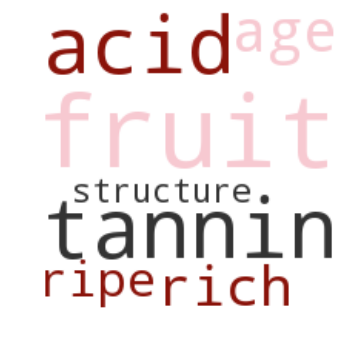

In [383]:
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return np.random.choice(['hsl(4, 86%, 29%)', 'hsl(4, 86%, 29%)', 'hsl(4, 86%, 29%)', 'hsl(4, 86%, 29%)',
                             'hsl(350, 75%, 88%)', 'hsl(0, 0%, 20%)', 'hsl(0, 0%, 20%)', 'hsl(0, 0%, 20%)'])

pos = 0
wordlist = ' '.join(sum([[x]*y for x,y in zip(km_word_list[1][pos][:7], range(10,0,-1))],[]))
wordcloud = WordCloud(background_color='white', color_func=color_func, width=200, height=200,
                      max_font_size=100, relative_scaling=.5).generate(wordlist)
plt.imshow(wordcloud)
plt.axis("off")
fig = plt.gcf()
fig.savefig('../figures/09_wine_enthusiast_lsa_clusters_{}.png'.format(pos+1),dpi=300)

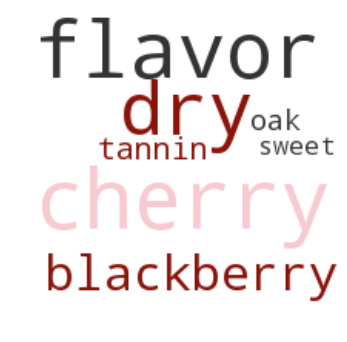

In [384]:
pos = 1
wordlist = ' '.join(sum([[x]*y for x,y in zip(km_word_list[1][pos][:7], range(10,0,-1))],[]))
wordcloud = WordCloud(background_color='white', color_func=color_func, width=200, height=200,
                      max_font_size=100, relative_scaling=.5).generate(wordlist)
plt.imshow(wordcloud)
plt.axis("off")
fig = plt.gcf()
fig.savefig('../figures/09_wine_enthusiast_lsa_clusters_{}.png'.format(pos+1),dpi=300)

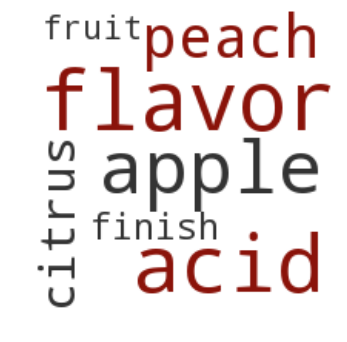

In [385]:
pos = 2
wordlist = ' '.join(sum([[x]*y for x,y in zip(km_word_list[1][pos][:7], range(10,0,-1))],[]))
wordcloud = WordCloud(background_color='white', color_func=color_func, width=200, height=200,
                      max_font_size=100, relative_scaling=.5).generate(wordlist)
plt.imshow(wordcloud)
plt.axis("off")
fig = plt.gcf()
fig.savefig('../figures/09_wine_enthusiast_lsa_clusters_{}.png'.format(pos+1),dpi=300)

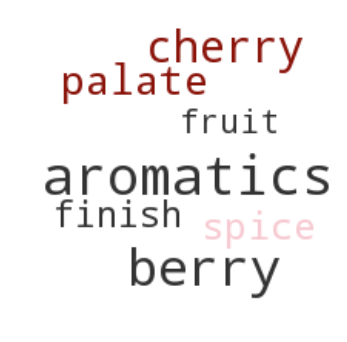

In [387]:
pos = 3
wordlist = ' '.join(sum([[x]*y for x,y in zip(km_word_list[1][pos][:7], range(10,0,-1))],[]))
wordcloud = WordCloud(background_color='white', color_func=color_func, width=200, height=200,
                      max_font_size=100, relative_scaling=.5).generate(wordlist)
plt.imshow(wordcloud)
plt.axis("off")
fig = plt.gcf()
fig.savefig('../figures/09_wine_enthusiast_lsa_clusters_{}.png'.format(pos+1),dpi=300)

## Visualizing K-means clusters

Unfortunately MDS never finished running, even overnight. Try T-SNE.

In [388]:
# TRY MDS
# T-SNE

In [411]:
X_lsa.shape

(29674, 30)

In [414]:
mds = MDS(n_components=2, 
          dissimilarity="precomputed", 
          random_state=1, n_jobs=1)

pca = PCA(n_components=2,
         copy=True)

def make_plot(clust):
    km = km_list[1]['km']
    X_km = km.fit_transform(X_lsa)
    clusters = km.predict(X_lsa)

    pos = mds.fit_transform(tfidf_cs)

    mds_data = pd.DataFrame(pos,columns=['xdata','ydata'])
    mds_data['cluster'] = clusters

    fig, ax = plt.subplots(figsize=(7,5))

    for idx,dat in mds_data.groupby('cluster'):
        print(dat.shape)
        ax.plot(dat.xdata, dat.ydata, marker='o', ls='', label=dat.cluster, alpha=0.5)
        ax.set(title=str(clust))
        
    return

In [ ]:
make_plot(4)

In [403]:
with open('../priv/pkl/09_wine_enthusiast_analysis_word_lemm.pkl','wb') as fh:
    dill.dump(data.word_lemm.tolist(), fh)